In [1]:
# Import necessary libraries
import os
import librosa
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from typing import List, Tuple, Union, Generator
import soundfile as sf
from tensorflow.keras.callbacks import EarlyStopping
from mutagen import File as MutagenFile
from itertools import islice
from tensorflow.keras.optimizers import Adam

# Configuration parameters
SAMPLE_RATE = 16000       # Sample rate for audio files
N_MELS = 128              # Number of mel bands for mel-spectrograms
HOP_LENGTH = 512          # Hop length for mel-spectrograms
FIXED_LENGTH = 300        # Fixed time length for spectrograms (in frames)
BATCH_SIZE = 8           # Batch size for training
EPOCHS = 1                # Number of training epochs
KFOLDS = 15                # Number of K-Fold cross-validation folds
DATA_LIMIT = 500        # Limit the number of samples to use
MIN_LENGTH_SECONDS = 6    # Minimum length of audio files to use
LEARNING_RATE = 1e-6      # Learning rate for the optimizer

# train_clean_path = '../../../data/audios/english/train/clean_trim'
# train_noisy_path = '../../../data/audios/english/train/blended_trim'
train_clean_path = '../../../data/audios/english/train/clean'
train_noisy_path = '../../../data/audios/english/train/blended'
train_noisy_path = '../../../data/audios/english/train/motor'



In [2]:
def normalize_audio(audio: np.ndarray) -> np.ndarray:
    """
    Normalize an audio signal to the range [-1, 1].

    Args:
        audio (np.ndarray): 1D array representing the audio signal.

    Returns:
        np.ndarray: Normalized audio signal in the range [-1, 1].
    """
    max_amplitude = np.max(np.abs(audio))
    return audio / max_amplitude if max_amplitude > 0 else audio

def load_audio_files_from_directory(
    directory: str, 
    extensions: List[str], 
    return_paths: bool = False, 
    min_length_seconds: int = 0
) -> Generator[Union[str, np.ndarray], None, None]:
    """
    Generator to load audio files from a directory and its subdirectories, yielding only
    those that meet the minimum length requirement. Automatically normalizes audio signals.

    Args:
        directory (str): Directory containing audio files.
        extensions (List[str]): List of acceptable file extensions.
        return_paths (bool): If True, yield file paths instead of loading audio data.
        min_length_seconds (int): Minimum length in seconds for audio files.

    Yields:
        Union[str, np.ndarray]: If return_paths=True, yields file paths; otherwise, yields normalized audio signals.
    """
    for root, _, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in extensions):
                file_path = os.path.join(root, file)

                # Get audio duration from metadata using mutagen
                audio_metadata = MutagenFile(file_path)
                if audio_metadata is not None and audio_metadata.info.length >= min_length_seconds:
                    if return_paths:
                        yield file_path
                    else:
                        # Load and normalize audio if file meets minimum duration requirement
                        audio, _ = librosa.load(file_path, sr=SAMPLE_RATE)
                        normalized_audio = normalize_audio(audio)
                        yield normalized_audio

def load_data(
    clean_dir: str, 
    noisy_dir: str, 
    limit: int = 100, 
    fixed_length: int = 300, 
    min_length_seconds: int = 6
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load audio files, convert them to fixed-length mel-spectrograms, and return as arrays.

    Args:
        clean_dir (str): Directory for clean audio files.
        noisy_dir (str): Directory for noisy audio files.
        limit (int): Maximum number of files to load.
        fixed_length (int): Fixed length for mel-spectrogram time dimension.
        min_length_seconds (int): Minimum audio length in seconds.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Arrays of clean and noisy mel-spectrograms.
    """
    clean_files = []
    noisy_files = []

    # Use generator to load files up to the specified limit
    for i, (clean_audio, noisy_audio) in enumerate(zip(
            load_audio_files_from_directory(clean_dir, ['.flac'], return_paths=False, min_length_seconds=min_length_seconds),
            load_audio_files_from_directory(noisy_dir, ['.mp3'], return_paths=False, min_length_seconds=min_length_seconds))):
        
        if i >= limit:
            break

        # Convert audio to mel-spectrograms
        clean_files.append(audio_to_mel_spectrogram(clean_audio, fixed_length=fixed_length))
        noisy_files.append(audio_to_mel_spectrogram(noisy_audio, fixed_length=fixed_length))

    # Convert lists to numpy arrays for model training
    return np.array(clean_files), np.array(noisy_files)

def mel_spectrogram_to_audio(mel_spectrogram_db: np.ndarray, sr: int = 16000, n_iter: int = 32, hop_length: int = 512) -> np.ndarray:
    """
    Convert a mel-spectrogram in dB scale back to audio waveform using Griffin-Lim algorithm.
    """
    mel_spectrogram = librosa.db_to_power(mel_spectrogram_db)
    audio = librosa.feature.inverse.mel_to_audio(mel_spectrogram, sr=sr, n_iter=n_iter, hop_length=hop_length)
    return audio

def denoise_audio(model: tf.keras.Model, noisy_audio_path: str, output_path: str) -> None:
    """
    Apply noise reduction on a noisy audio file and save the cleaned audio.
    
    Args:
        model (tf.keras.Model): Trained noise reduction model.
        noisy_audio_path (str): Path to the noisy audio file.
        output_path (str): Path where the denoised audio will be saved.
    """
    # Load the noisy audio
    noisy_audio, sr = librosa.load(noisy_audio_path, sr=16000)
    
    # Convert the audio to mel-spectrogram without fixed-length truncation
    noisy_mel_spectrogram = audio_to_mel_spectrogram(noisy_audio, sr=sr, n_mels=128, hop_length=512, fixed_length=FIXED_LENGTH)

    # Prepare input for the model
    noisy_mel_spectrogram = noisy_mel_spectrogram[np.newaxis, ..., np.newaxis]
    
    # Predict the clean spectrogram
    predicted_clean_mel_spectrogram = model.predict(noisy_mel_spectrogram)[0, ..., 0]
    
    # Convert the predicted spectrogram back to audio
    cleaned_audio = mel_spectrogram_to_audio(predicted_clean_mel_spectrogram, sr=sr, hop_length=512)

    # Save the cleaned audio
    sf.write(output_path, cleaned_audio, sr)

def denoise_audio_and_return_spectrogram(model: tf.keras.Model, noisy_audio_path: str) -> np.ndarray:
    """
    Apply noise reduction on a noisy audio file and return the predicted clean mel-spectrogram.
    
    Args:
        model (tf.keras.Model): Trained noise reduction model.
        noisy_audio_path (str): Path to the noisy audio file.

    Returns:
        np.ndarray: Predicted clean mel-spectrogram.
    """
    # Load noisy audio
    noisy_audio, sr = librosa.load(noisy_audio_path, sr=16000)
    
    # Convert noisy audio to mel-spectrogram
    noisy_mel_spectrogram = audio_to_mel_spectrogram(noisy_audio, fixed_length=FIXED_LENGTH)
    noisy_mel_spectrogram = noisy_mel_spectrogram[np.newaxis, ..., np.newaxis]

    # Predict clean mel-spectrogram
    predicted_clean_mel_spectrogram = model.predict(noisy_mel_spectrogram)[0, ..., 0]
    
    return predicted_clean_mel_spectrogram

def audio_to_mel_spectrogram(audio: np.ndarray, sr: int = 16000, n_mels: int = 128, hop_length: int = 512, fixed_length: int = 600) -> np.ndarray:
    """
    Convert an audio signal to a fixed-length mel-spectrogram in dB scale.
    """
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # Pad or truncate to fixed length
    if mel_spectrogram_db.shape[1] < fixed_length:
        mel_spectrogram_db = np.pad(mel_spectrogram_db, ((0, 0), (0, fixed_length - mel_spectrogram_db.shape[1])), mode='constant')
    else:
        mel_spectrogram_db = mel_spectrogram_db[:, :fixed_length]
    
    return mel_spectrogram_db

def plot_individual_clean_noisy_mel_spectrograms(noisy_file_paths: List[str], clean_file_paths: List[str], num_pairs: int = 10):
    """
    Plot individual mel-spectrogram comparisons for clean and noisy (blended) audio files.
    
    Args:
        noisy_file_paths (List[str]): List of paths to the noisy audio files.
        clean_file_paths (List[str]): List of paths to the corresponding clean audio files.
        num_pairs (int): Number of pairs to display (default is 10).
    """
    for idx, (noisy_path, clean_path) in enumerate(zip(noisy_file_paths[:num_pairs], clean_file_paths[:num_pairs])):
        # Load audio data
        noisy_audio = librosa.load(noisy_path, sr=16000)[0]
        clean_audio = librosa.load(clean_path, sr=16000)[0]

        # Convert audio to mel-spectrograms
        noisy_mel_spectrogram = audio_to_mel_spectrogram(noisy_audio, fixed_length=FIXED_LENGTH)
        clean_mel_spectrogram = audio_to_mel_spectrogram(clean_audio, fixed_length=FIXED_LENGTH)
        
        # Create a new figure for each pair
        fig, axes = plt.subplots(2, 1, figsize=(10, 6))
        fig.suptitle(f"Mel-Spectrogram Comparison for:\nNoisy: {os.path.basename(noisy_path)} | Clean: {os.path.basename(clean_path)}")

        # Plot noisy mel-spectrogram
        sns.heatmap(noisy_mel_spectrogram, ax=axes[0], cmap='magma', cbar=False)
        axes[0].set_title("Noisy (Blended)")
        axes[0].set_xlabel("Time")
        axes[0].set_ylabel("Frequency")

        # Plot clean mel-spectrogram
        sns.heatmap(clean_mel_spectrogram, ax=axes[1], cmap='magma', cbar=False)
        axes[1].set_title("Clean")
        axes[1].set_xlabel("Time")
        axes[1].set_ylabel("Frequency")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title
        plt.show()

def plot_comparisons_for_first_10(model, noisy_file_paths: List[str], clean_file_paths: List[str], num_pairs: int = 10):
    """
    Plot comparisons of blended, predicted, and clean mel-spectrograms for the first 10 files.
    
    Args:
        model (tf.keras.Model): Trained noise reduction model.
        noisy_file_paths (List[str]): List of paths to the noisy audio files.
        clean_file_paths (List[str]): List of paths to the corresponding clean audio files.
        num_pairs (int): Number of pairs to display (default is 10).
    """
    for idx, (noisy_path, clean_path) in enumerate(zip(noisy_file_paths[:num_pairs], clean_file_paths[:num_pairs])):
        # Load and process files
        noisy_audio = librosa.load(noisy_path, sr=16000)[0]
        clean_audio = librosa.load(clean_path, sr=16000)[0]

        # Convert to mel-spectrograms
        noisy_mel_spectrogram = audio_to_mel_spectrogram(noisy_audio, fixed_length=FIXED_LENGTH)
        clean_mel_spectrogram = audio_to_mel_spectrogram(clean_audio, fixed_length=FIXED_LENGTH)
        
        # Get predicted clean mel-spectrogram
        predicted_clean_mel_spectrogram = denoise_audio_and_return_spectrogram(model, noisy_path)
        
        # Plot comparisons
        fig, axes = plt.subplots(3, 1, figsize=(10, 9))
        fig.suptitle(f"Mel-Spectrogram Comparison for:\nNoisy: {os.path.basename(noisy_path)} | Clean: {os.path.basename(clean_path)}")

        # Blended (Noisy) Mel-Spectrogram
        sns.heatmap(noisy_mel_spectrogram, ax=axes[0], cmap='magma', cbar=False)
        axes[0].set_title("Noisy (Blended)")
        axes[0].set_xlabel("Time")
        axes[0].set_ylabel("Frequency")

        # Predicted Clean Mel-Spectrogram
        sns.heatmap(predicted_clean_mel_spectrogram, ax=axes[1], cmap='magma', cbar=False)
        axes[1].set_title("Predicted Clean")
        axes[1].set_xlabel("Time")
        axes[1].set_ylabel("Frequency")

        # True Clean Mel-Spectrogram
        sns.heatmap(clean_mel_spectrogram, ax=axes[2], cmap='magma', cbar=False)
        axes[2].set_title("True Clean")
        axes[2].set_xlabel("Time")
        axes[2].set_ylabel("Frequency")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title
        plt.show()

def plot_loss_and_metrics_separate(histories):
    """
    Plot MSE and MAE curves with subplots for training and validation in each figure.
    
    Args:
        histories (List[tf.keras.callbacks.History]): Training histories from K-Fold cross-validation.
    """
    # Extract metrics for each fold
    mse_train, mse_val, mae_train, mae_val = [], [], [], []
    for history in histories:
        mse_train.append(history.history['loss'])
        mse_val.append(history.history['val_loss'])
        mae_train.append(history.history['mae'])
        mae_val.append(history.history['val_mae'])
    
    # Plot MSE with subplots for training and validation
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    fig.suptitle("Mean Squared Error (MSE)", fontsize=16)
    
    for i, (train_mse, val_mse) in enumerate(zip(mse_train, mse_val)):
        axes[0].plot(range(1, len(train_mse) + 1), train_mse, label=f'Fold {i+1}')
        axes[1].plot(range(1, len(val_mse) + 1), val_mse, label=f'Fold {i+1}')
        
    axes[0].set_title("Training MSE")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("MSE")
    axes[1].set_title("Validation MSE")
    axes[1].set_xlabel("Epochs")

    # Add shared y-axis label for both subplots
    fig.text(0.5, 0.04, 'Epochs', ha='center')
    fig.text(0.04, 0.5, 'MSE', va='center', rotation='vertical')

    # Show legends and set integer x-axis ticks
    for ax in axes:
        ax.legend()
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.grid(True, color='lightgray')

    plt.show()

    # Plot MAE with subplots for training and validation
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    fig.suptitle("Mean Absolute Error (MAE)", fontsize=16)

    for i, (train_mae, val_mae) in enumerate(zip(mae_train, mae_val)):
        axes[0].plot(range(1, len(train_mae) + 1), train_mae, label=f'Fold {i+1}')
        axes[1].plot(range(1, len(val_mae) + 1), val_mae, label=f'Fold {i+1}')
    
    axes[0].set_title("Training MAE")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("MAE")
    axes[1].set_title("Validation MAE")
    axes[1].set_xlabel("Epochs")

    # Add shared y-axis label for both subplots
    fig.text(0.5, 0.04, 'Epochs', ha='center')
    fig.text(0.04, 0.5, 'MAE', va='center', rotation='vertical')

    # Show legends and set integer x-axis ticks
    for ax in axes:
        ax.legend()
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.grid(True, color='lightgray')

    plt.show()


In [3]:
def build_unet_model(input_shape: Tuple[int, int, int]) -> tf.keras.Model:
    """
    Build a U-Net-like CNN model adapted for mel-spectrogram denoising.

    Args:
        input_shape (Tuple[int, int, int]): Shape of input mel-spectrograms.

    Returns:
        tf.keras.Model: Compiled U-Net model.
    """
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2), padding='same')(conv1)

    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2), padding='same')(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

    # Decoder
    up1 = layers.UpSampling2D((2, 2))(conv3)
    upconv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    concat1 = layers.Concatenate()([upconv1, conv2])

    up2 = layers.UpSampling2D((2, 2))(concat1)
    upconv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
    concat2 = layers.Concatenate()([upconv2, conv1])

    outputs = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(concat2)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [4]:
def train_with_kfold(noisy_data, clean_data, input_shape, k: int = 5, epochs: int = 20, batch_size: int = 8,
                     learning_rate: float = 1e-6):
    """
    Train the model using K-Fold cross-validation and save the last trained model.

    Args:
        noisy_data (np.ndarray): Noisy mel-spectrogram data.
        clean_data (np.ndarray): Clean mel-spectrogram data.
        input_shape (Tuple[int, int, int]): Shape of input mel-spectrograms.
        k (int): Number of folds for K-Fold cross-validation.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
    """
    histories = []
    kfold = KFold(n_splits=k, shuffle=True)

    for fold, (train_idx, val_idx) in enumerate(kfold.split(noisy_data)):
        print(f"Training fold {fold + 1}")
        # Initialize and compile the model
        model = build_unet_model(input_shape)
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

        # Split into training and validation data
        X_train, X_val = noisy_data[train_idx], noisy_data[val_idx]
        y_train, y_val = clean_data[train_idx], clean_data[val_idx]

        # Early stopping to avoid overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Train the model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping]
        )
        histories.append(history)

        # If this is the last fold, save the model
        if fold == k - 1:
            model.save('ML-DAN_v3.2.keras')
            model.save('ML-DAN_v3.2.h5')

    return histories


In [5]:
# Load data and prepare for training
train_clean, train_noisy = load_data(train_clean_path, train_noisy_path,
                                     limit=DATA_LIMIT, fixed_length=FIXED_LENGTH, min_length_seconds=MIN_LENGTH_SECONDS)
train_noisy = train_noisy[..., np.newaxis]  # Add channel dimension for model input
train_clean = train_clean[..., np.newaxis]

# Set minimum and maximum values for normalization
min_val, max_val = -80.0, 0.0

# Normalize the data to the range [0, 1]
train_noisy = (train_noisy - min_val) / (max_val - min_val)
train_clean = (train_clean - min_val) / (max_val - min_val)

print("Noisy normalized min:", np.min(train_noisy), "max:", np.max(train_noisy))
print("Clean normalized min:", np.min(train_clean), "max:", np.max(train_clean))

# Кількість аудіофайлів
print("Number of noisy audio samples:", train_noisy.shape[0])
print("Number of clean audio samples:", train_clean.shape[0])


Noisy normalized min: 0.0 max: 1.0
Clean normalized min: 0.0 max: 1.0
Number of noisy audio samples: 500
Number of clean audio samples: 500


In [6]:
# Load data and retrieve file names using a generator
train_clean_paths = list(islice(load_audio_files_from_directory(train_clean_path, ['.flac'], return_paths=True, min_length_seconds=MIN_LENGTH_SECONDS), 3))
train_noisy_paths = list(islice(load_audio_files_from_directory(train_noisy_path, ['.mp3'], return_paths=True, min_length_seconds=MIN_LENGTH_SECONDS), 3))

# Extract just the file names from the full paths
clean_file_names = [os.path.basename(path) for path in train_clean_paths]
noisy_file_names = [os.path.basename(path) for path in train_noisy_paths]

# Print the first 10 names
print("First 3 pairs of file names (clean, noisy):")
for clean, noisy in zip(clean_file_names, noisy_file_names):
    print(f"Clean: {clean}, Noisy: {noisy}")


First 3 pairs of file names (clean, noisy):
Clean: 103-1240-0000.flac, Noisy: 103-1240-0000.mp3
Clean: 103-1240-0001.flac, Noisy: 103-1240-0001.mp3
Clean: 103-1240-0002.flac, Noisy: 103-1240-0002.mp3


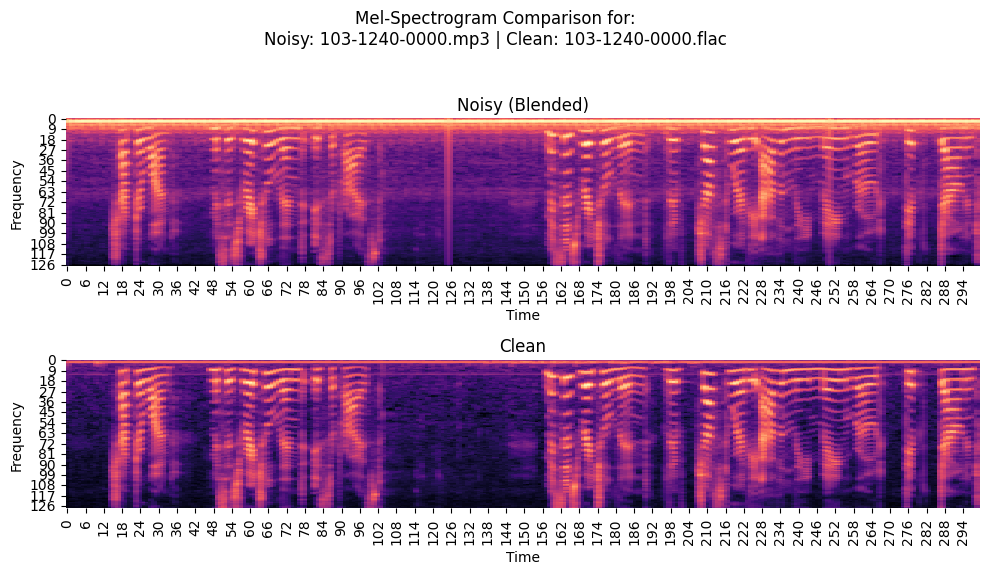

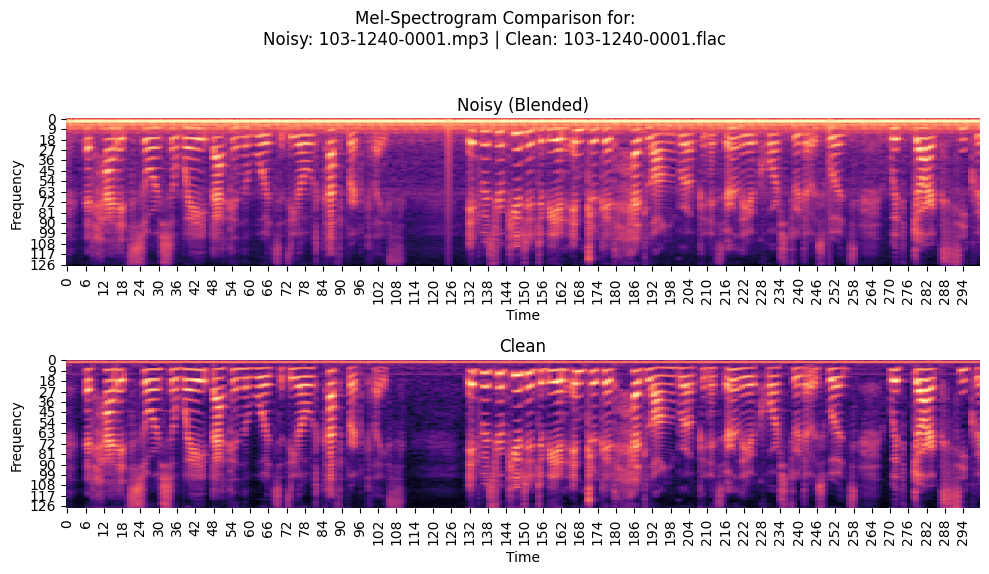

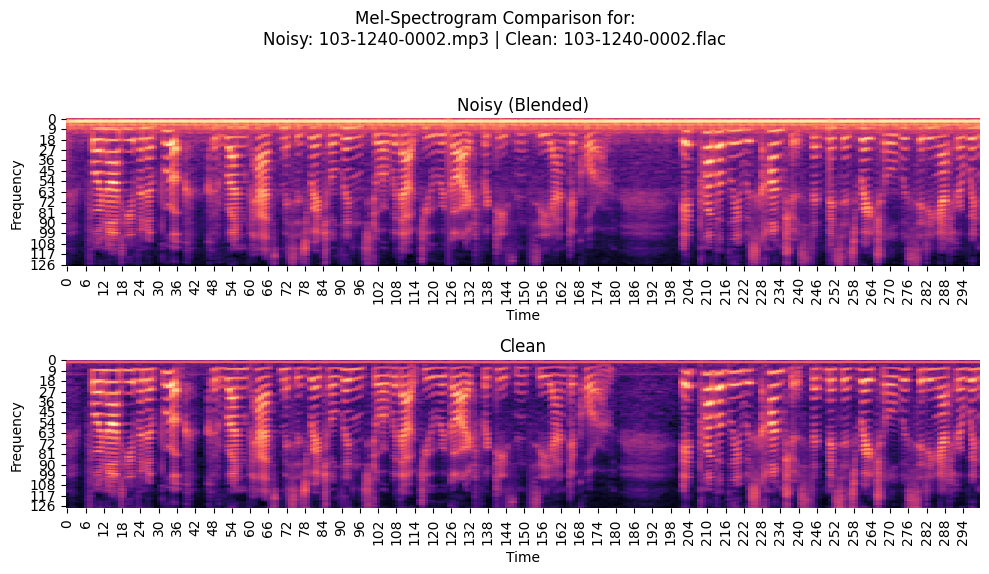

In [7]:
# Plot mel-spectrogram comparisons for the first 10 pairs
plot_individual_clean_noisy_mel_spectrograms(train_noisy_paths, train_clean_paths, num_pairs=3)


In [8]:
# Train model with K-Fold cross-validation
input_shape = train_noisy.shape[1:]  # (128, 300, 1) for mel-spectrograms
histories = train_with_kfold(train_noisy, train_clean, input_shape=input_shape, k=KFOLDS, epochs=EPOCHS, batch_size=BATCH_SIZE,
                             learning_rate=LEARNING_RATE)


Training fold 1
59/59 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - loss: 0.0651 - mae: 0.2093 - val_loss: 0.0569 - val_mae: 0.1942
Training fold 2
59/59 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - loss: 0.0634 - mae: 0.2052 - val_loss: 0.0674 - val_mae: 0.2126
Training fold 3
59/59 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - loss: 0.0631 - mae: 0.2058 - val_loss: 0.0727 - val_mae: 0.2214
Training fold 4
59/59 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - loss: 0.0655 - mae: 0.2106 - val_loss: 0.0610 - val_mae: 0.2018
Training fold 5
59/59 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - loss: 0.0622 - mae: 0.2049 - val_loss: 0.0686 - val_mae: 0.2181
Training fold 6
59/59 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - loss: 0.0652 - mae: 0.2091 - val_loss: 0.0581 - val_mae: 0.1975
Training fold 7
59/59 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - loss: 0.0633 - mae: 0.2076 - val_loss: 0.0652 - val_mae: 0.2122
Training fold 8
59/59 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - loss: 0.0632 - mae: 0.2047 - val_loss: 0.0637 - val_mae: 0.2046
Training fold 9
59/59 ━━

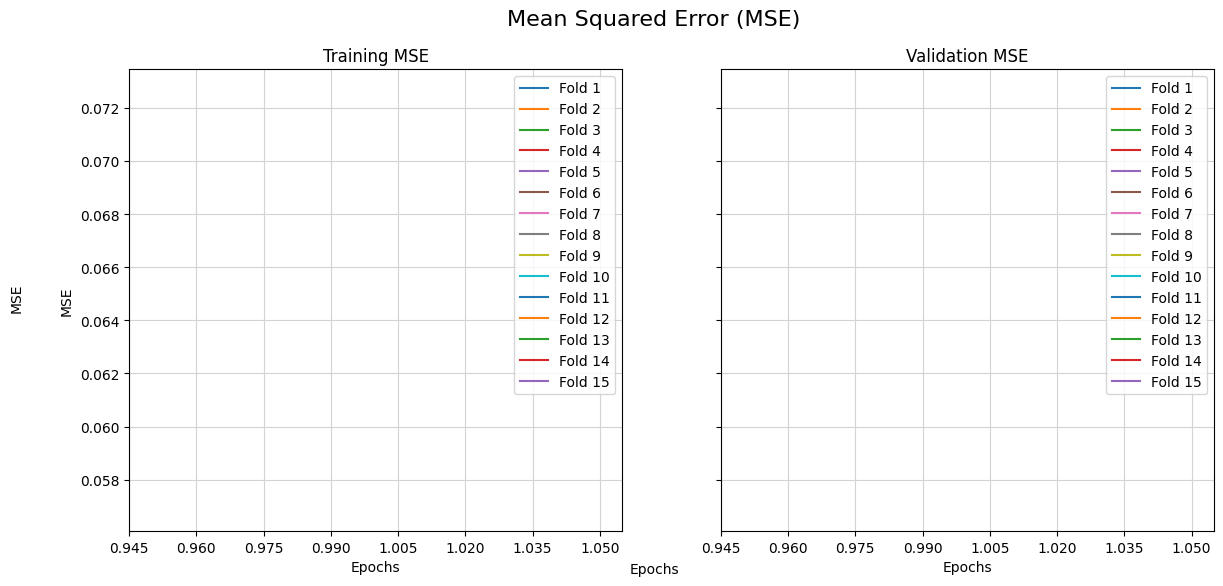

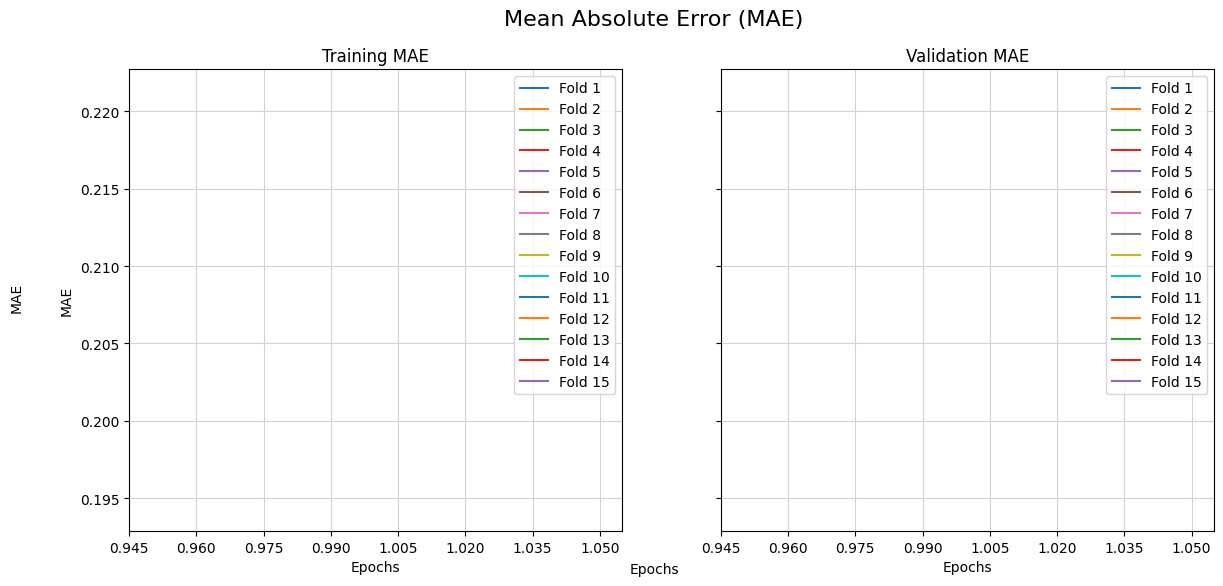

In [9]:
# Call the function to plot metrics
plot_loss_and_metrics_separate(histories)

In [10]:
# Load the saved model
model = tf.keras.models.load_model('ML-DAN_v3.2.keras')

# Function to denoise and save the audio
INPUT_DATA = '../../../data/audios/english/train/blended/19-198-0012.mp3'
OUTPUT_DATA = 'testV3.wav'
denoise_audio(model, INPUT_DATA, OUTPUT_DATA)

# Play the denoised audio file in Jupyter
Audio(INPUT_DATA)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


In [11]:
Audio(OUTPUT_DATA)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


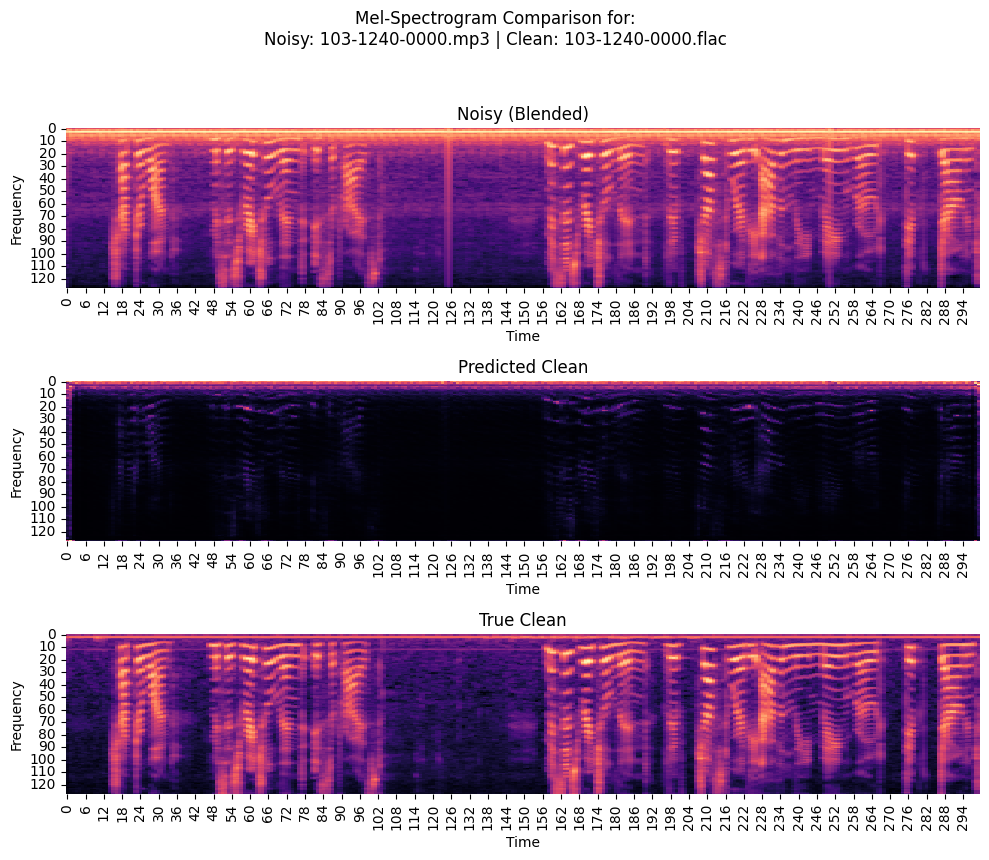

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


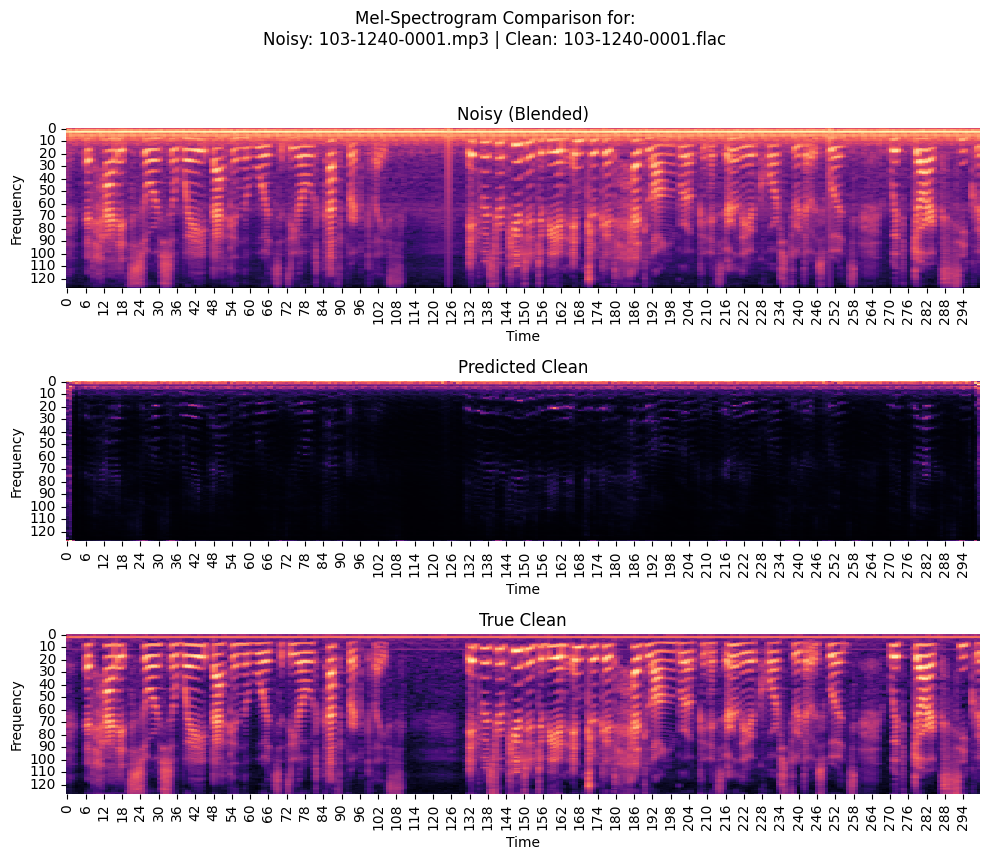

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


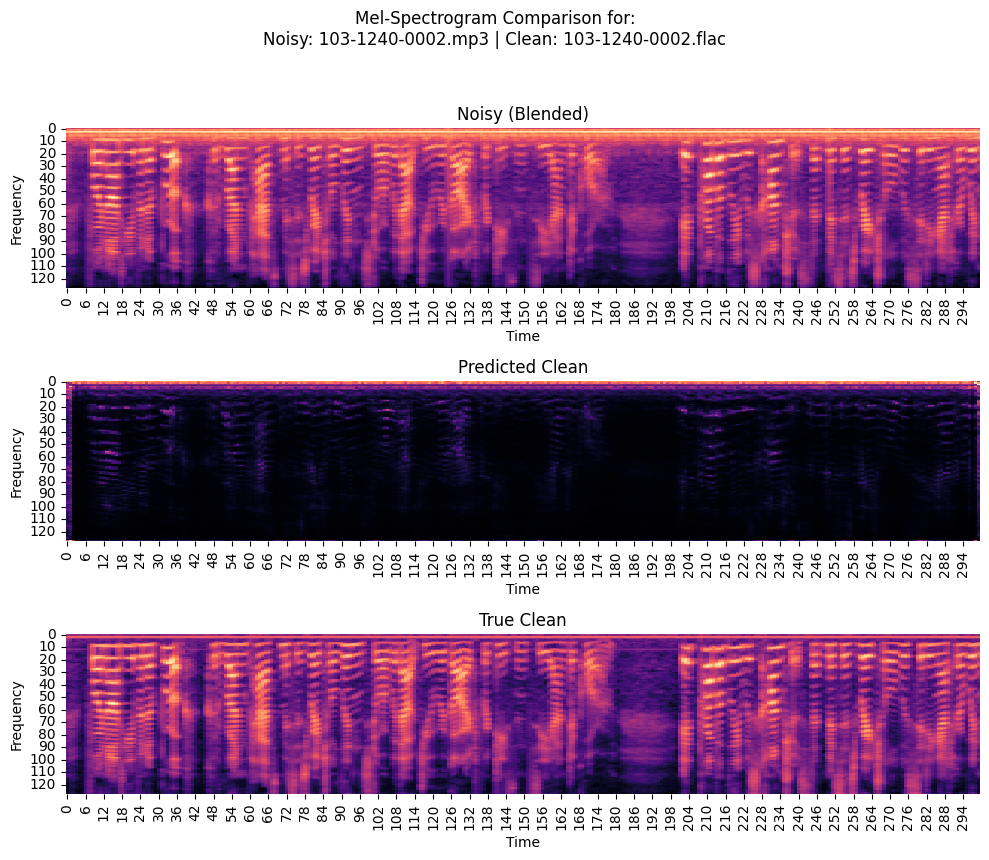

In [12]:
# Plot comparisons for the first 10 files
plot_comparisons_for_first_10(model, train_noisy_paths, train_clean_paths, num_pairs=10)
